# Cleaning raw data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import os

In [2]:
xlsx_path = "../input_folder/cleaned dataset 2020-2023.xlsx"

In [60]:
yrs = ["2020", "2021", "2022", "2023"]
dfs = []

def read_raw_data(yr):
    df = pd.read_excel(xlsx_path, sheet_name=yr)
    df.set_index("ID2", drop=False, inplace=True)

    # clean string columns
    for c in ["Gender", "Ward", 'Type of Sample']:
        df[c] = df[c].str.strip().str.title()

    for c in ["Organism"]:
        df[c] = df[c].str.strip().str.capitalize()

    for c in ["Type of AMR"]:
        df[c] = df[c].str.strip()
    df["Type of AMR"].replace({"": np.nan, "-": np.nan}, inplace=True)
    
    to_replace = {
        'Acinetobacter baumanii': 'Acinetobacter baumannii',
        'Aeromonas hydrophilia': 'Aeromonas hydrophila',
        'Enterobacteriacae': 'Enterobacteriaceae',
        'Flaviobacterium spp': 'Flavobacterium spp',
        'Klebsiella spp.': 'Klebsiella spp',
        'Providencia  stuartii': 'Providencia stuartii',
        'Streptococcus group c': 'Streptococcus Group C'
    }
    
    df["Organism"] = df["Organism"].replace(to_replace)

    
    df["Year"] = int(yr)
    # df["Year"] = pd.to_datetime(yr, format="%Y")
    
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='%d/%m/%Y')
    reference_date = pd.Timestamp('2025-02-01')
    df['Age'] = (reference_date - df['Date of Birth']).dt.days // 365

    df['Date of Request'] = pd.to_datetime(df['Date of Request'], format='%d/%m/%Y')
    
    return df

    
for yr in yrs:
    sdf = read_raw_data(yr)
    dfs.append(sdf)

df = pd.concat(dfs)
df.sort_values("Year", inplace=True)


/tmp/ipykernel_15618/1918428633.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Type of AMR"].replace({"": np.nan, "-": np.nan}, inplace=True)
/tmp/ipykernel_15618/1918428633.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [61]:
print(f"Number of rows: {df.shape[0]}")

Number of rows: 18330


Columns: 

In [62]:
df.columns.tolist()

['ID',
 'ID2',
 'Gender',
 'Date of Birth',
 'Age',
 'Date of Request',
 'Ward',
 'Type of Sample',
 'Organism',
 'Type of AMR',
 'Year']

Cleaning data, problems from raw data:

- Gender: `['Male', 'Female', 'Male ', 'male ']`
- Date of Birth
- Age

Dates, I'm assuming it follows the format `%d/%m/%Y`, and I recalculate age too.

## How many entries per year?

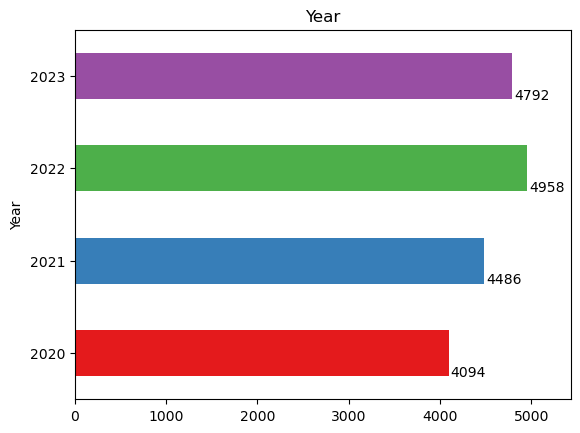

In [63]:
a = df["Year"].value_counts()
a = a[[2020, 2021, 2022, 2023]]
ax = a.plot(kind="barh", color=plt.cm.Set1.colors)

for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)

plt.title("Year")
plt.show()

## Gender

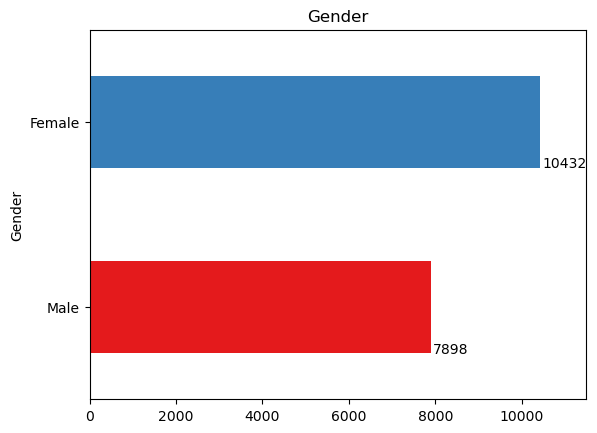

In [64]:
ax = df['Gender'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y() * 1.005))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Gender")

plt.show()

## Date of Birth

In [65]:
eldest = df["Date of Birth"].min()
youngest = df["Date of Birth"].max()

print(f"""Eldest: {eldest},
Youngest: {youngest}""")

Eldest: 1907-01-01 00:00:00,
Youngest: 2023-12-24 10:15:28


## Age

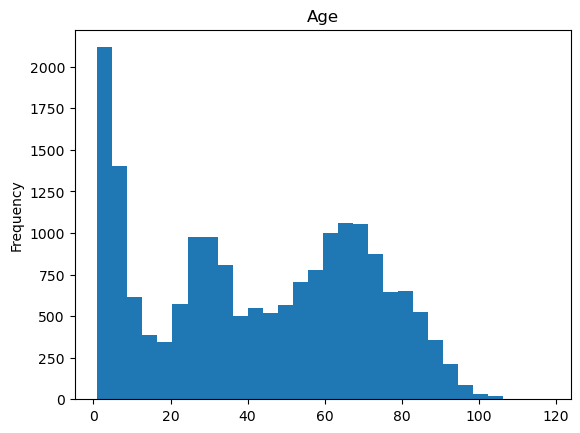

In [66]:
df["Age"].sort_values().plot(kind="hist", bins=30)
plt.title("Age")
plt.show()

## Date of Request

In [67]:
for yr in yrs:
    yr = int(yr)
    earliest = df.loc[df["Year"] == yr, :]["Date of Request"].min()
    latest = df.loc[df["Year"] == yr, :]["Date of Request"].max()
    
    
    print(f"""Year: {yr},
    Earliest: {earliest},
    Latest: {latest}""")
    print()

Year: 2020,
    Earliest: 2020-01-01 00:00:00,
    Latest: 2020-12-01 00:00:00

Year: 2021,
    Earliest: 2021-01-01 00:00:00,
    Latest: 2021-12-01 00:00:00

Year: 2022,
    Earliest: 2022-01-01 00:00:00,
    Latest: 2022-12-01 00:00:00

Year: 2023,
    Earliest: 2022-06-01 00:00:00,
    Latest: 2023-12-31 09:14:28



Something weird going on with the date:

- Most of the years, sample collection ended on 1st Dec?
- Earliest sample on 2023 is on 1st June?

## Ward

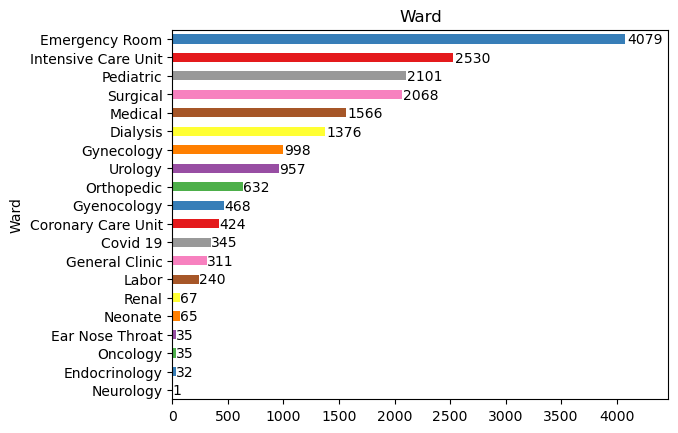

In [68]:
ax = df['Ward'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Ward")

plt.show()

## Type of Sample

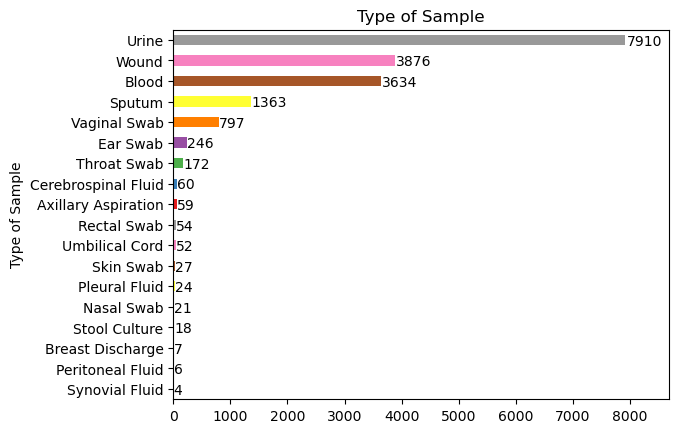

In [69]:
ax = df['Type of Sample'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Type of Sample")

plt.show()

## Organism

In [70]:
org = df['Organism'].value_counts().to_dict()
org = dict(sorted(org.items()))
all_organisms = list(org.keys())

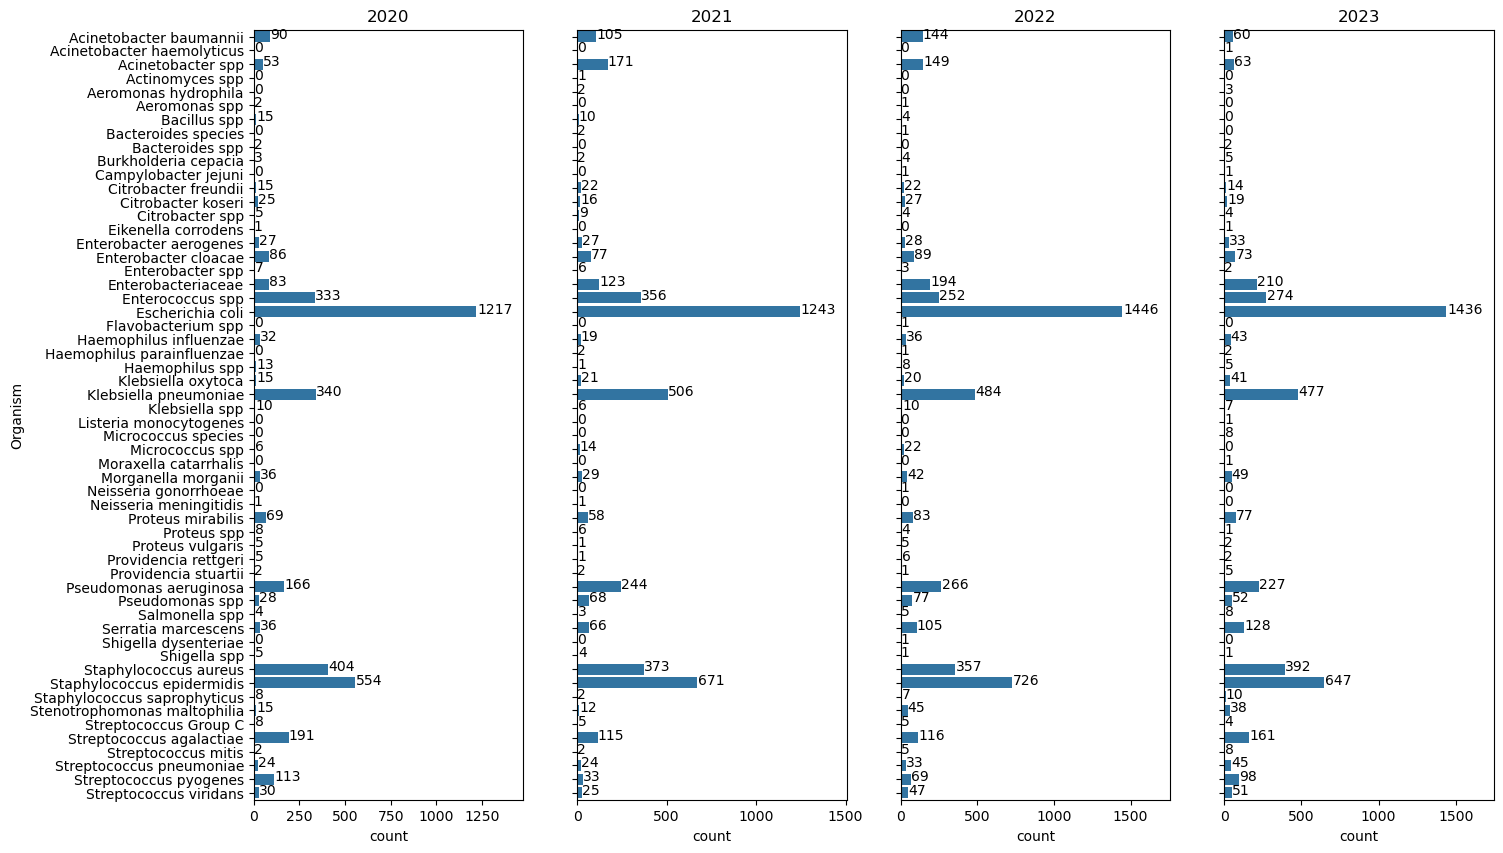

In [71]:
fig, axs = plt.subplots(ncols = 4, figsize=(16,10), dpi=100, sharey=True)
axs = axs.ravel()

# yearly_counts = {}

for idx, yr in enumerate(yrs):
    yr = int(yr)

    subset = df.loc[df["Year"] == yr, :].value_counts("Organism")
    subset = subset.reindex(all_organisms, fill_value=0)  # Fill missing organisms with 0
    subset = pd.DataFrame(subset)
    # yearly_counts[yr] = subset
    subset["count"] = subset["count"].astype(int)
    # subset["count"] = subset["count"].round()

    ax = axs[idx]
    sns.barplot(data=subset, x="count", y=subset.index, ax=ax)

    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), ( p.get_width() * 1.005, p.get_y()+0.5))
    ax.set_xlim(0, ax.get_xlim()[1]**1.02)
    
    ax.set_title(yr)

plt.show()

## Type of AMR

In [72]:
amrs = df['Type of AMR'].value_counts().to_dict()
amrs = dict(sorted(amrs.items()))
all_amrs = list(amrs.keys())

Types of AMR:

In [74]:
all_amrs

['AMP-RHI',
 'CR-AB',
 'CR-PA',
 'CRE',
 'CRE CP Producer',
 'ESBL-EC',
 'ESBL-KP',
 'MAC-RSP',
 'MAC-RSPN',
 'MRSA',
 'MRSE',
 'PEN-R',
 'VRE']

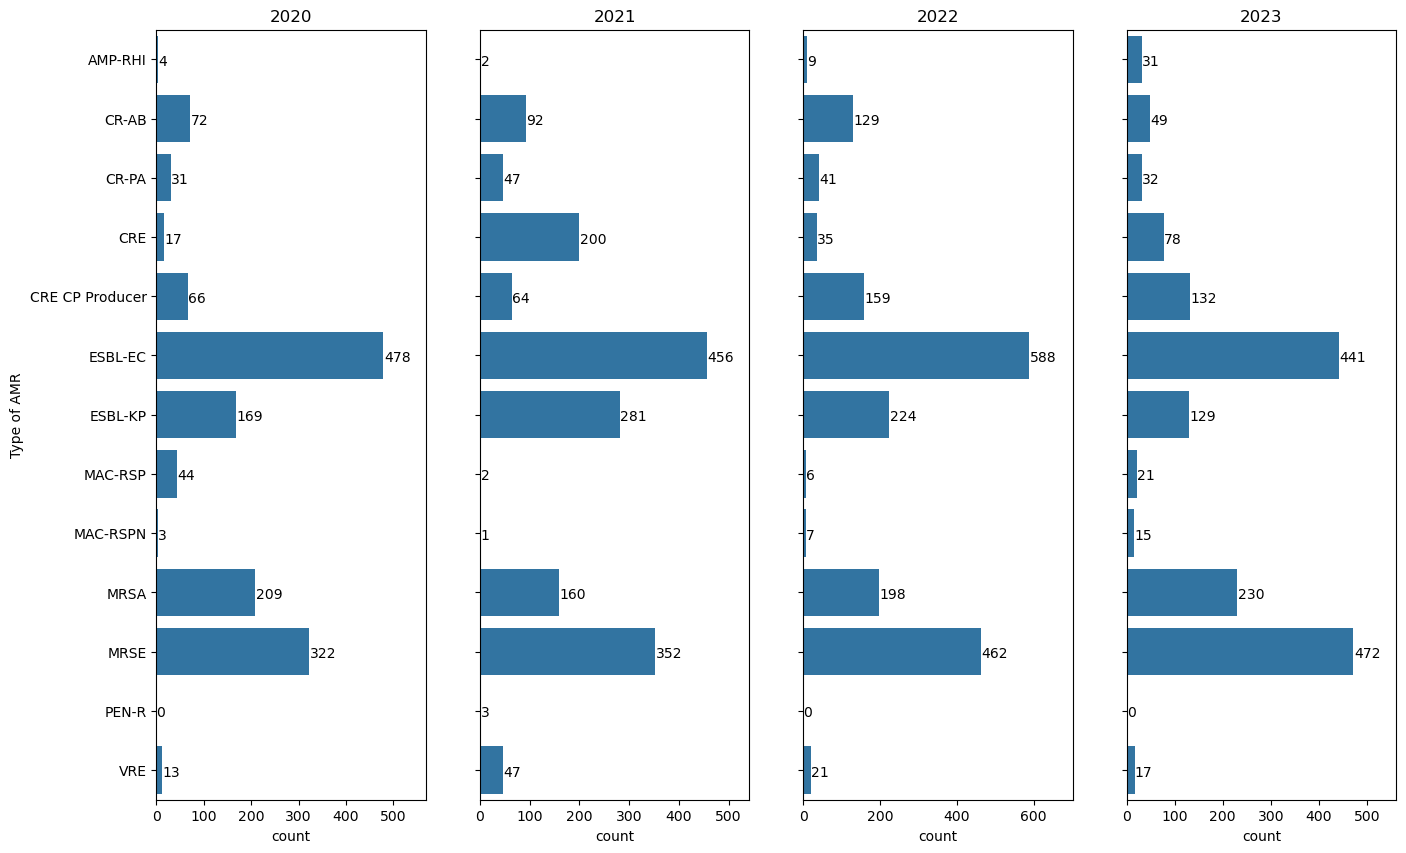

In [75]:
fig, axs = plt.subplots(ncols = 4, figsize=(16,10), dpi=100, sharey=True)
axs = axs.ravel()


for idx, yr in enumerate(yrs):
    yr = int(yr)

    subset = df.loc[df["Year"] == yr, :].value_counts("Type of AMR")
    subset = subset.reindex(all_amrs, fill_value=0)  # Fill missing organisms with 0
    subset = pd.DataFrame(subset)
    
    subset["count"] = subset["count"].astype(int)
    
    ax = axs[idx]
    sns.barplot(data=subset, x="count", y=subset.index, ax=ax)

    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), ( p.get_width() * 1.005, p.get_y()+0.5))
    ax.set_xlim(0, ax.get_xlim()[1]**1.02)
    
    ax.set_title(yr)

plt.show()